In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set(style="darkgrid")
pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows",1000):
        with pd.option_context("display.max_columns",1000):
            display(df)
    

In [4]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [6]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [7]:
train_original=train.copy()
test_original=test.copy()

In [8]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [9]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.6873
N    0.3127
Name: Loan_Status, dtype: float64

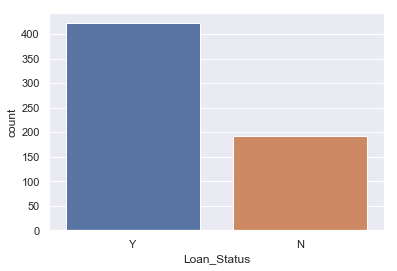

In [10]:
ax = sns.countplot(x="Loan_Status", data=train)

In [11]:
display_all(train.head().T)

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0,1508,0,2358,0
LoanAmount,NaN,128,66,120,141
Loan_Amount_Term,360,360,360,360,360


In [12]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [13]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

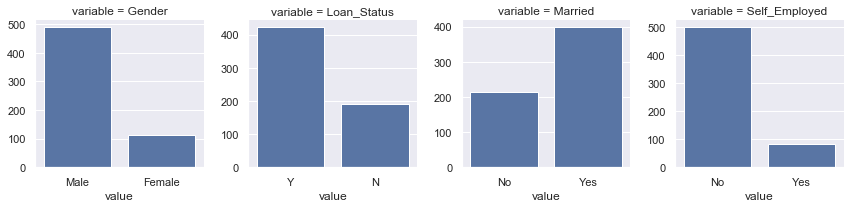

In [14]:
f = pd.melt(train, value_vars=sorted(categorical_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

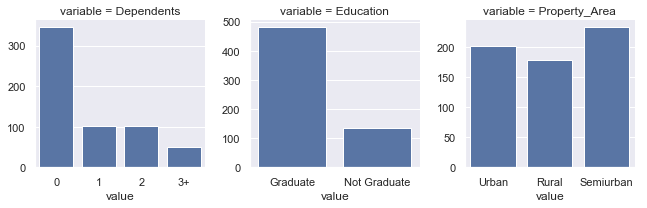

In [15]:
f = pd.melt(train, value_vars=sorted(ordinal_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

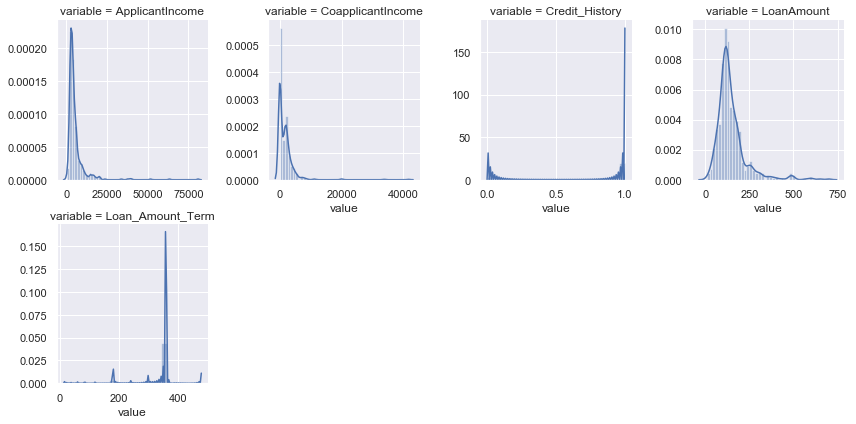

In [16]:
f = pd.melt(train, value_vars=sorted(continuous_ds))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

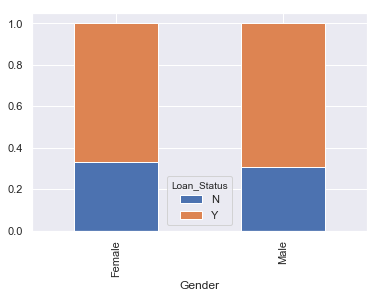

In [17]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.div(gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [18]:
train.groupby(['Gender','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Gender  Credit_History  Loan_Status
Female  0.0             N               16
                        Y                1
        1.0             N               20
                        Y               64
Male    0.0             N               63
                        Y                6
        1.0             N               75
                        Y              307
Name: Loan_ID, dtype: int64

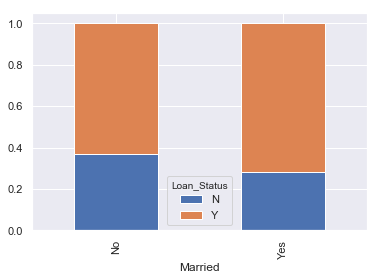

In [19]:
married=pd.crosstab(train['Married'],train['Loan_Status'])
married.div(married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [20]:
train.groupby(['Married','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Married  Credit_History  Loan_Status
No       0.0             N               29
                         Y                3
         1.0             N               45
                         Y              122
Yes      0.0             N               53
                         Y                4
         1.0             N               52
                         Y              253
Name: Loan_ID, dtype: int64

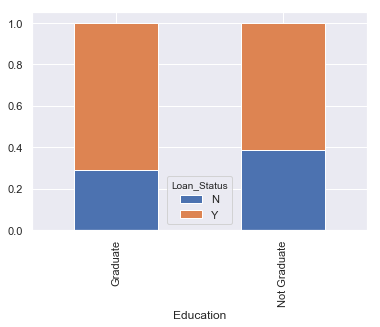

In [21]:
education=pd.crosstab(train['Education'],train['Loan_Status'])
education.div(education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [22]:
train.groupby(['Education','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Credit_History  Loan_Status
Graduate      0.0             N               57
                              Y                6
              1.0             N               73
                              Y              307
Not Graduate  0.0             N               25
                              Y                1
              1.0             N               24
                              Y               71
Name: Loan_ID, dtype: int64

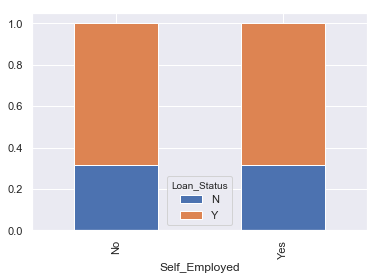

In [23]:
self_employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
self_employed.div(self_employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [24]:
train.groupby(['Education','Self_Employed','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Education     Self_Employed  Credit_History  Loan_Status
Graduate      No             0.0             N               46
                                             Y                6
                             1.0             N               62
                                             Y              249
              Yes            0.0             N               10
                             1.0             N                9
                                             Y               41
Not Graduate  No             0.0             N               23
                                             Y                1
                             1.0             N               19
                                             Y               57
              Yes            0.0             N                2
                             1.0             N                4
                                             Y                9
Name: Loan_ID, dtype: int64

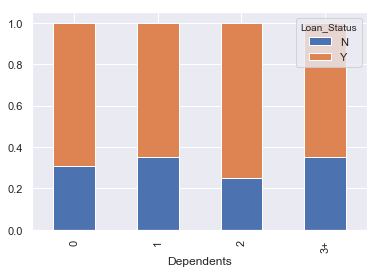

In [25]:
#Credit_History
dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.div(dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [26]:
train.groupby(['Dependents','Credit_History','Loan_Status'])['Loan_ID'].count().reindex()

Dependents  Credit_History  Loan_Status
0           0.0             N               42
                            Y                3
            1.0             N               60
                            Y              211
1           0.0             N               13
                            Y                1
            1.0             N               17
                            Y               59
2           0.0             N               13
                            Y                1
            1.0             N               12
                            Y               69
3+          0.0             N                9
                            Y                2
            1.0             N                7
                            Y               30
Name: Loan_ID, dtype: int64

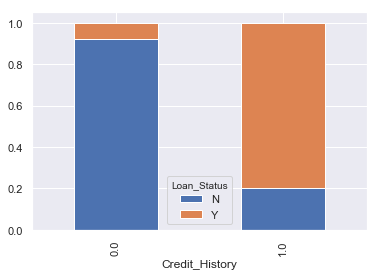

In [27]:
#Credit_History
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

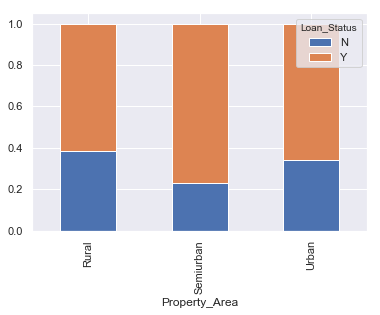

In [28]:
PropertyArea=pd.crosstab(train['Property_Area'],train['Loan_Status'])
PropertyArea.div(PropertyArea.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [29]:
train.groupby(['Property_Area','Loan_Status'])['Loan_ID'].count().reindex()

Property_Area  Loan_Status
Rural          N               69
               Y              110
Semiurban      N               54
               Y              179
Urban          N               69
               Y              133
Name: Loan_ID, dtype: int64

In [30]:
test[ (test['Credit_History'].notnull()) &(test['Dependents']!='0')]['Credit_History'].value_counts()

1.0    127
0.0     26
Name: Credit_History, dtype: int64

In [31]:
Credit_History_Married=pd.crosstab(train['Credit_History'],train['Married'],train['Loan_Status'],margins=True, aggfunc='count')
Credit_History_Married

Married,No,Yes,All
Credit_History,,,
0.0,32,57,89
1.0,167,305,472
All,199,362,561


In [32]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.1433
3,Self_Employed,32,5.2117
4,LoanAmount,22,3.5831
2,Dependents,15,2.4430
5,Loan_Amount_Term,14,2.2801
0,Gender,13,2.1173
1,Married,3,0.4886


In [33]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.9019
2,Self_Employed,23,6.2670
0,Gender,11,2.9973
1,Dependents,10,2.7248
4,Loan_Amount_Term,6,1.6349
3,LoanAmount,5,1.3624


In [34]:
#train_credit_null_index = train[(train['Married']=='Yes') &
#                                (train['CoapplicantIncome']!=0) 
#                                &(train['Credit_History'].isnull())].index.tolist()
#test_credit_null_index=test[(test['Married']=='Yes') & 
#                            (test['CoapplicantIncome']!=0) &
#                            (test['Credit_History'].isnull())].index.tolist()

#train.loc[train_credit_null_index,'Credit_History']=1
#test.loc[test_credit_null_index,'Credit_History']=1

train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

 
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True)
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train_Married_null_index = train[ 
                                (train['CoapplicantIncome']!=0) 
                                &(train['Married'].isnull())].index.tolist()

train.loc[train_Married_null_index,'Married']='Yes'
train['Married'].fillna('No',inplace=True)

In [35]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
0,LoanAmount,22,3.5831


In [36]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
0,LoanAmount,5,1.3624


In [37]:
def emi_calculator(row): 
    r = 5.6 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 
 

In [38]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [39]:
property_map = {'Rural':1,'Urban':2,'Semiurban':3}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) +1
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-(full_dataset['EMI']) +1
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']

full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']

#full_dataset['Loan_Amount_Term']= full_dataset['Loan_Amount_Term']/12
#full_dataset["Graduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["Graduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["NotGraduate_with_GoodCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History']=='1.0')) * 1
#full_dataset["NotGraduate_with_BadCreditHistory"] = ((full_dataset["Education"] == "Not Graduate")& (full_dataset['Credit_History'] =='0.0')) * 1
#full_dataset["Married_CoApplicant_NoDependents"] = ((full_dataset["Married"] == 1) & 
#                                                    (full_dataset['Dependents'] =='0')&
#                                                    (full_dataset['HasCoApplicant']=='Y')
#
#) * 1
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)


In [40]:
#full_dataset["Married_NoDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["Married_WithDependents"] = ((full_dataset["Married"] == 1) & (full_dataset['Dependents'] !=0)) * 1
#full_dataset["NotMarried_NoDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] ==0)) * 1
#full_dataset["NotMarried_WithDependents"] = ((full_dataset["Married"] == 0) & (full_dataset['Dependents'] !=0)) * 1
full_dataset.head()


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
0,5849,0.0,1.0,0,Graduate,1,130.0,360.0,LP001002,1.0,0,2,No,5849.0,N,746.3027,5103.6973,5103.6973,44.9923,44.9923
1,4583,1508.0,1.0,1,Graduate,1,128.0,360.0,LP001003,0.0,1,1,No,6091.0,Y,734.8211,5357.1789,3849.1789,35.8047,47.5859
2,3000,0.0,1.0,0,Graduate,1,66.0,360.0,LP001005,1.0,1,2,Yes,3000.0,N,378.8921,2622.1079,2622.1079,45.4545,45.4545
3,2583,2358.0,1.0,0,Not Graduate,1,120.0,360.0,LP001006,1.0,1,2,No,4941.0,Y,688.8948,4253.1052,1895.1052,21.5250,41.1750
4,6000,0.0,1.0,0,Graduate,1,141.0,360.0,LP001008,1.0,0,2,No,6000.0,N,809.4514,5191.5486,5191.5486,42.5532,42.5532


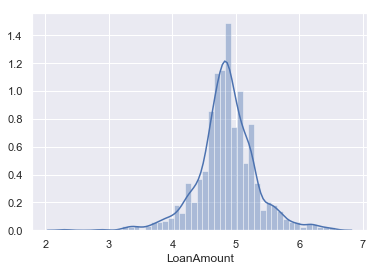

In [41]:
sns.distplot(np.log1p(full_dataset['LoanAmount']))

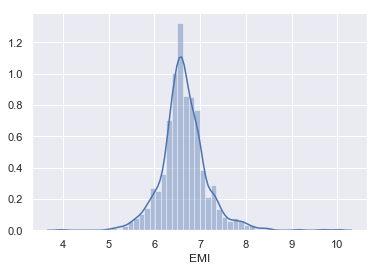

In [42]:
sns.distplot(np.log1p(full_dataset['EMI']))

In [43]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

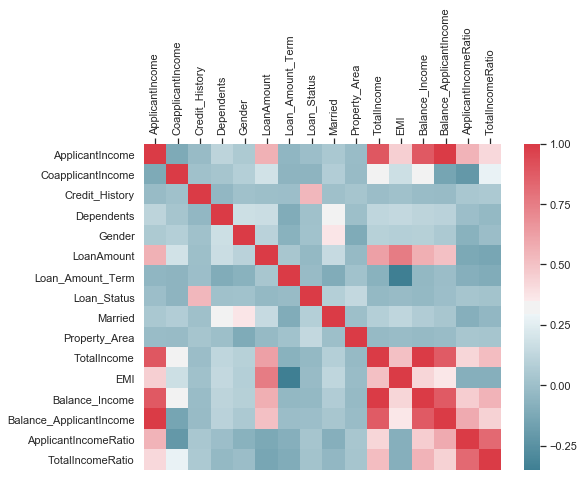

In [44]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#correlation = correlation.sort_values('Loan_Status', ascending=False)
#plt.figure(figsize=(8,10))
#sns.barplot( correlation['Loan_Status'][1:], correlation.index[1:], orient='h')
#plt.show()

In [45]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 'Balance_Income','ApplicantIncome',
                   ],axis=1,inplace=True)

full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
scaler = LogTransformer(['EMI','LoanAmount'])
full_dataset =scaler.fit_transform(full_dataset)

In [46]:
def evaluvate_model(clf ,X_trainmodel, y_trainmodel,X_val,y_val): 
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf, 
                                                                  X_trainmodel,y_trainmodel.values.ravel(),cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val,y_val,clf)
    y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                               show_classification_report=True,
                               show_confusion_matrix=True, show_r2_score=False)



In [47]:
null_dataset =get_nullframe(full_dataset)
null_dataset

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [48]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [49]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=10)

(614, 14)
(367, 14)


In [50]:
X_trainmodel.head()

,Credit_History,Dependents,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,EMI,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Education_Graduate,Self_Employed_Yes,HasCoApplicant_Y
92,1.0,2,1,4.4067,360.0,1,2,6.1442,2808.9960,40.4074,62.8765,0,0,1
304,1.0,0,1,4.9488,360.0,0,1,6.6905,3197.2894,28.5714,46.4286,1,0,1
68,1.0,3,1,4.8363,60.0,1,2,7.7809,4707.5808,56.8000,56.8000,0,1,0
15,1.0,0,1,4.8363,360.0,0,2,6.5773,4233.4013,39.6000,39.6000,1,0,0
211,0.0,3,1,4.8598,360.0,1,3,6.6010,2696.1789,26.7969,36.5625,1,0,1


Accuracy: 77.273
Accuracy: 82.609


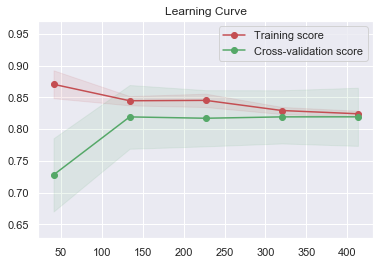

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Best Penalty: l1
Best C: 21.544346900318832
Accuracy: 82.391


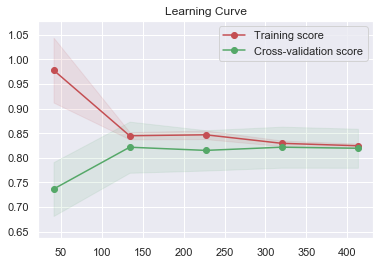

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02, 4.64159e+02,
       2.15443e+03, 1.00000e+04, 4.64159e+04, 2.15443e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Classification report
              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54        54
         1.0       0.75      0.97      0.84       100

   micro avg       0.77      0.77      0.77       154
   macro avg       0.81      0.68      0.69       154
weighted avg      

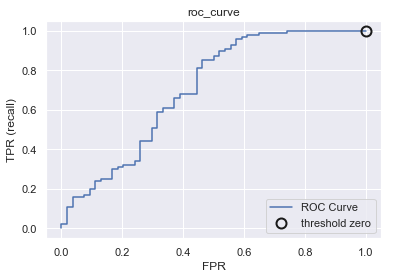

In [51]:
from sklearn.linear_model import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel, y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))
logrmodel ,result = test_classifier(logrmodel,X_trainmodel,y_trainmodel,kfold)
print(logrmodel)

# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 6, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
clf = GridSearchCV(logrmodel, hyperparameters, cv=5, verbose=0,scoring='accuracy')
best_model = clf.fit(X_trainmodel, y_trainmodel.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

best_lr_model ,result = test_classifier(best_model,X_trainmodel,y_trainmodel,kfold)
print(best_lr_model)

y_pred=measure_performance(X_val,y_val,best_lr_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_lr_model)

In [52]:
from xgboost.sklearn import XGBClassifier

In [53]:
xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [54]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Accuracy: 89.783


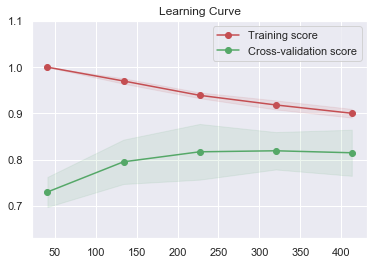

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


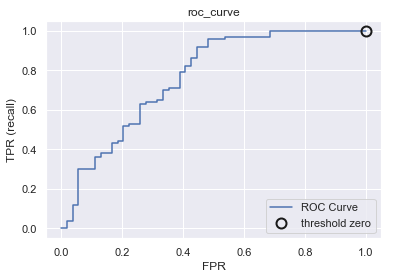

In [55]:
best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)

plot_roc(X_val,y_val,best_model)



In [56]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

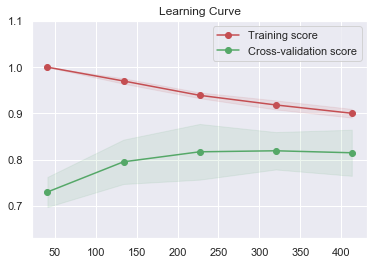

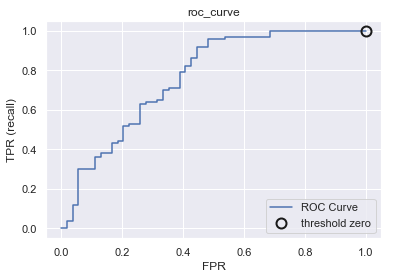

Classification report
              precision    recall  f1-score   support

         0.0       0.80      0.52      0.63        54
         1.0       0.78      0.93      0.85       100

   micro avg       0.79      0.79      0.79       154
   macro avg       0.79      0.72      0.74       154
weighted avg       0.79      0.79      0.77       154

Confusion matrix
[[28 26]
 [ 7 93]]


In [57]:
evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [58]:
 def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [59]:
Check

NameError: name 'Check' is not defined

In [60]:
import xgboost as xgb
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 0.7,
          'colsample_bylevel': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          }

In [87]:
params2 = {'booster':'gbtree', 
'colsample_bylevel':1,
'gamma':0.21, 
'learning_rate':0.1,
'max_delta_step':0, 
'max_depth':3, 
'min_child_weight':1, 
'missing':None,
'n_estimators':150, 
'n_jobs':1, 
'nthread':4, 
"objective": "multi:softmax",
'num_class': 2,
'random_state':0, 
'reg_alpha':0.01, 
'reg_lambda':1, 
'scale_pos_weight':1,
'silent':True,
'subsample':0.7
          }

num_boost_round =60

print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params2, dtrain, num_boost_round, watchlist, feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.163043	eval-merror:0.214286	train-accuracy_score:0.836957	eval-accuracy_score:0.785714
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[2]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[3]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[4]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[5]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[6]	train-merror:0.158696	eval-merror:0.220779	train-accuracy_score:0.841304	eval-accuracy_score:0.779221
[7]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	ev

Text(0.5,0,'relative importance')

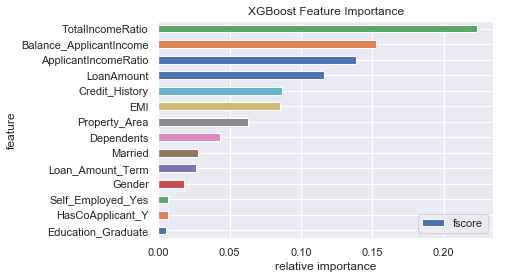

In [88]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [89]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

 
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_XgBooost"+timestamp+"_out.csv"

submission.to_csv(filename)

### Public Leaderboard - Practice Problem: Loan Prediction III
### Rank 156/35442		KrishnaMohan	0.8055555556

Accuracy: 88.478


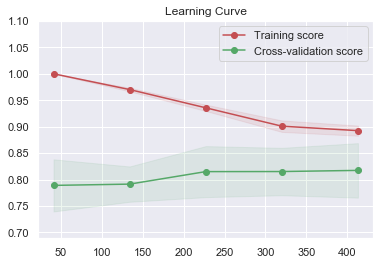

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=10,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=6,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              n_iter_no_change=None, presort='auto', random_state=2,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Classification report
              precision    recall  f1-score   support

         0.0       0.85      0.52      0.64        54
         1.0       0.79      0.95      0.86       100

   micro avg       0.80      0.80      0.80       154
   macro avg       0.82      0.73      0.75       154
weighted avg       0.81      0.80      0.78       154

Confusion matrix
[[28 26]
 [ 5 95]]


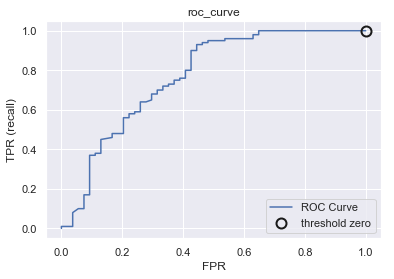

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
original_params = {'n_estimators':40, 'max_leaf_nodes':10, 'max_depth': 3, 'random_state': 2,
                   'min_samples_split':6,'min_samples_leaf':5,'learning_rate':0.1 }

gbc =GradientBoostingClassifier(**original_params)
gbc.fit(X_trainmodel, y_trainmodel.values.ravel())
 
best_gc =  gbc
best_gc ,result = test_classifier(best_gc,X_trainmodel,y_trainmodel,kfold)
print(best_gc)

y_pred=measure_performance(X_val,y_val,best_gc, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,best_gc)

In [65]:
test_y =best_gc.predict(test_X)

submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_GradientBoosting"+timestamp+"_out.csv"

#submission.to_csv(filename)

In [66]:
X_trainmodel.head()

,Credit_History,Dependents,Gender,LoanAmount,Loan_Amount_Term,Married,Property_Area,EMI,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Education_Graduate,Self_Employed_Yes,HasCoApplicant_Y
92,1.0,2,1,4.4067,360.0,1,2,6.1442,2808.9960,40.4074,62.8765,0,0,1
304,1.0,0,1,4.9488,360.0,0,1,6.6905,3197.2894,28.5714,46.4286,1,0,1
68,1.0,3,1,4.8363,60.0,1,2,7.7809,4707.5808,56.8000,56.8000,0,1,0
15,1.0,0,1,4.8363,360.0,0,2,6.5773,4233.4013,39.6000,39.6000,1,0,0
211,0.0,3,1,4.8598,360.0,1,3,6.6010,2696.1789,26.7969,36.5625,1,0,1


In [67]:
params = {'booster':'gbtree', 
'colsample_bylevel':1,
'colsample_bytree':0.6, 
'gamma':0.3, 
'learning_rate':0.1,
'max_delta_step':0, 
'max_depth':5, 
'min_child_weight':3, 
'missing':None,
'n_estimators':13, 
'n_jobs':1, 
'nthread':4, 
'objective':'binary:logistic',
'random_state':0, 
'reg_alpha':0.01, 
'reg_lambda':1, 
'scale_pos_weight':1,
'seed':27,
'silent':True,
'subsample':0.7
          }

clf = xgb.XGBClassifier(**params)

clf.fit(X_trainmodel,y_trainmodel,
        eval_set=[(X_trainmodel,y_trainmodel), (X_val,y_val)],
        eval_metric=calc_accuracy,
        verbose=True)

evals_result = clf.evals_result()

[0]	validation_0-error:0.176087	validation_1-error:0.233766	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[1]	validation_0-error:0.173913	validation_1-error:0.220779	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[2]	validation_0-error:0.173913	validation_1-error:0.227273	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[3]	validation_0-error:0.169565	validation_1-error:0.227273	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[4]	validation_0-error:0.169565	validation_1-error:0.220779	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[5]	validation_0-error:0.165217	validation_1-error:0.220779	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[6]	validation_0-error:0.158696	validation_1-error:0.220779	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[7]	validation_0-error:0.165217	validation_1-error:0.233766	validation_0-accuracy_score:0	validation_1-accuracy_score:0
[8]	validation_0-error:0.156522	validati

In [ ]:
y_pred=measure_performance(X_val,y_val,clf, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

plot_roc(X_val,y_val,clf)

In [ ]:
def modelfit(alg, dtrain, predictors, target='Loan_Status',useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_stdv =False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric=calc_accuracy)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
predictors = [x for x in X_trainmodel.columns if x not in ['Loan_Status','LoanStatus']]
xgb1 = XGBClassifier(learning_rate =0.1,n_estimators=1000,
                     max_depth=5,min_child_weight=1,gamma=0,
                     subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27)
trainmodel =X_trainmodel
trainmodel['Loan_Status'] =y_trainmodel
trainmodel.head()
modelfit(xgb1, trainmodel, predictors)

In [ ]:
X_trainmodel.head()

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_trainmodel,y_trainmodel)
gsearch1.best_params_, gsearch1.best_score_
best_estimator=gsearch1.best_estimator_

In [ ]:
param_test2b = {
 'min_child_weight':[1,2,3,5,8]
}
gsearch2 = GridSearchCV(estimator = best_estimator, 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_trainmodel,y_trainmodel)
gsearch2.best_params_, gsearch1.best_score_

In [ ]:
best_estimator=gsearch2.best_estimator_

In [ ]:
modelfit(best_estimator, trainmodel, predictors)

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = best_estimator, param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_trainmodel,y_trainmodel)
print(gsearch3.best_params_, gsearch3.best_score_)
best_estimator=gsearch3.best_estimator_
print(best_estimator)

In [ ]:
modelfit(best_estimator, trainmodel, predictors)

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(5,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch4 = GridSearchCV(estimator = best_estimator, param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_trainmodel,y_trainmodel)
print(gsearch4.best_params_, gsearch4.best_score_)
best_estimator=gsearch4.best_estimator_
print(best_estimator)

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(60,100,5)],
 'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
gsearch5 = GridSearchCV(estimator = best_estimator, param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_trainmodel,y_trainmodel)
print(gsearch5.best_params_, gsearch4.best_score_)
best_estimator=gsearch5.best_estimator_
print(best_estimator)

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = best_estimator, param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_trainmodel,y_trainmodel)
print(gsearch6.best_params_, gsearch6.best_score_)
best_estimator=gsearch6.best_estimator_
print(best_estimator)

In [ ]:
param_test7 = {
 'reg_alpha':[0.1,0.0, 1e-5, 1e-2,]
}
gsearch7 = GridSearchCV(estimator = best_estimator, param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X_trainmodel,y_trainmodel)
print(gsearch7.best_params_, gsearch7.best_score_)
best_estimator=gsearch7.best_estimator_
print(best_estimator)

In [ ]:
modelfit(best_estimator, trainmodel, predictors)

In [ ]:
xgbclf =XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=13, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.7)
modelfit(xgbclf, trainmodel, predictors)

In [ ]:
test_y =xgbclf.predict(test_X)
test_y[0:10]

In [ ]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_XgBooost"+timestamp+"_out.csv"

submission.to_csv(filename)